# Task 4: Predictive Modeling & Risk Analytics

## Objective
The goal of this notebook is to build a robust predictive modeling pipeline for auto insurance data. We will focus on two key modeling tasks:
1.  **Claim Severity Prediction**: predicting the cost of a claim (Regression).
2.  **Claim Frequency Prediction**: predicting the probability of a claim occurring (Classification).

Finally, we will combine these models to calculate a **Risk-Based Premium** for each policy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import shap
import warnings
warnings.filterwarnings('ignore')

# Set Plotting Style
sns.set_style('whitegrid')

c:\Users\ruths\Desktop\10AcademyWeek0\Insurance-Risk-Analytics-Predictive-Modeling-week3\new_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define constants
FILE_PATH = "../data/MachineLearningRating_v3.txt"
SEPARATOR = "|"
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
# --- 1. Data Preparation Pipeline ---

def prepare_data(df):
    """Handles missing values, feature engineering, and categorical encoding."""
    
    # Drop columns that are identifiers or have high cardinality/low utility
    cols_to_drop = [
        'UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'MainCrestaZone', 
        'SubCrestaZone', 'ItemType', 'Model', 'VehicleIntroDate'
    ]
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # Inspect and drop columns that are entirely missing to prevent NaN errors later
    df = df.dropna(axis=1, how='all')

    # Impute Numerical Missing Data
    # Using broadly applied median imputation for all numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if col not in ['TotalClaims', 'TotalPremium', 'HasClaim']: 
            df[col] = df[col].fillna(df[col].median())
    
    # Impute Categorical Missing Data with 'Missing'
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].fillna('Missing')
    
    # Drop rows where 'TotalClaims' or 'TotalPremium' might still be NaN (safety check)
    df.dropna(subset=['TotalClaims', 'TotalPremium'], inplace=True)
    
    # Feature Engineering (Example: Vehicle Age)
    current_year = pd.Timestamp.now().year
    if 'RegistrationYear' in df.columns:
         df['VehicleAge'] = current_year - df['RegistrationYear']
    
    # Create the binary Claim Frequency target
    df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

    # Encoding Categorical Data (One-Hot Encoding)
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    return df

In [4]:
# --- 2. Load & Prepare Data ---

try:
    df = pd.read_csv(FILE_PATH, sep=SEPARATOR, low_memory=False)
    print(f"Data loaded successfully with shape: {df.shape}")
    
    print("Running data preparation...")
    df_prepared = prepare_data(df)
    print(f"Data prepared. New shape: {df_prepared.shape}")
    
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}. Please check your path.")
    raise

Data loaded successfully with shape: (1000098, 52)
Running data preparation...
Data prepared. New shape: (1000098, 870)


## 2. Exploratory Data Analysis (EDA)
Before modeling, let's look at the distribution of our target variable `TotalClaims` to understand the data skew.

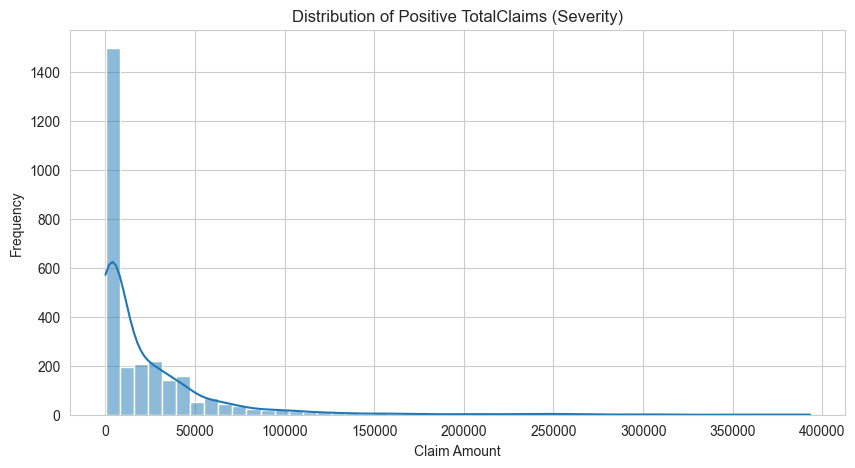

Claim Ratio: 0.28%


In [5]:
plt.figure(figsize=(10, 5))
sns.histplot(df_prepared[df_prepared['TotalClaims'] > 0]['TotalClaims'], bins=50, kde=True)
plt.title('Distribution of Positive TotalClaims (Severity)')
plt.xlabel('Claim Amount')
plt.ylabel('Frequency')
plt.show()

print(f"Claim Ratio: {df_prepared['HasClaim'].mean():.2%}")

## 3. Modeling Pipeline 1: Claim Severity (Regression)
We filter the data to only include records where a claim occurred (`HasClaim == 1`).

In [6]:
# a. Severity Dataset Creation
df_severity = df_prepared[df_prepared['HasClaim'] == 1].copy()

# Drop targets and non-features
drop_cols_sev = ['TotalClaims', 'HasClaim', 'TotalPremium', 'RegistrationYear']
X_sev = df_severity.drop(columns=[c for c in drop_cols_sev if c in df_severity.columns])
y_sev = df_severity['TotalClaims']

# Split data
X_sev_train, X_sev_test, y_sev_train, y_sev_test = train_test_split(
    X_sev, y_sev, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print(f"Severity Train/Test Split: {X_sev_train.shape}, {X_sev_test.shape}")

Severity Train/Test Split: (2230, 866), (558, 866)


In [7]:
# b. Model Training
xgb_model = XGBRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
print("Training XGBoost Regressor...")
xgb_model.fit(X_sev_train, y_sev_train)
print("Training complete.")

Training XGBoost Regressor...
Training complete.



Severity Model Performance:
RMSE: 37740.44
R2 Score: 0.1144


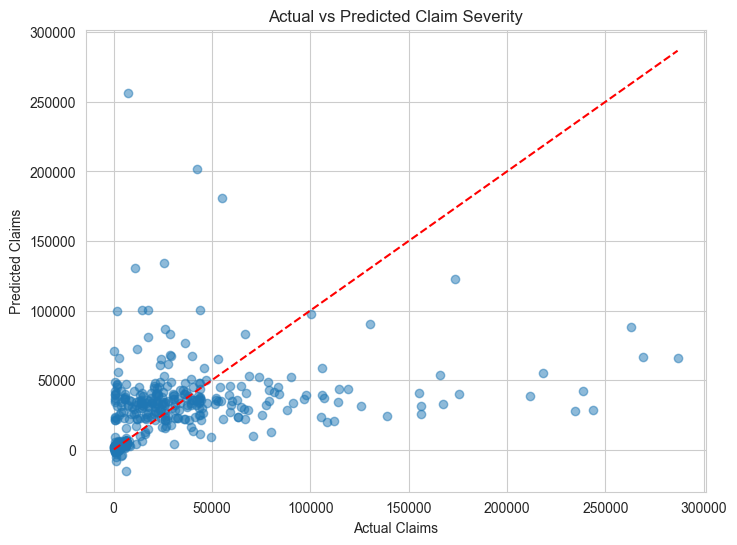

In [8]:
# c. Evaluation
y_pred_sev = xgb_model.predict(X_sev_test)
rmse = np.sqrt(mean_squared_error(y_sev_test, y_pred_sev))
r2 = r2_score(y_sev_test, y_pred_sev)

print(f"\nSeverity Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_sev_test, y_pred_sev, alpha=0.5)
plt.plot([y_sev_test.min(), y_sev_test.max()], [y_sev_test.min(), y_sev_test.max()], 'r--')
plt.xlabel('Actual Claims')
plt.ylabel('Predicted Claims')
plt.title('Actual vs Predicted Claim Severity')
plt.show()

## 4. Modeling Pipeline 2: Claim Probability (Classification)
We use the entire dataset to predict whether a policy will have a claim or not.

In [9]:
# a. Frequency Dataset Creation
drop_cols_freq = ['TotalClaims', 'HasClaim', 'TotalPremium', 'RegistrationYear']
X_freq = df_prepared.drop(columns=[c for c in drop_cols_freq if c in df_prepared.columns])
y_freq = df_prepared['HasClaim']

# Align columns with severity model (optional but good practice)
X_freq = X_freq.reindex(columns=X_sev.columns, fill_value=0)

X_freq_train, X_freq_test, y_freq_train, y_freq_test = train_test_split(
    X_freq, y_freq, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_freq
)

In [10]:
# b. Model Training
# Use scale_pos_weight to handle class imbalance (Claims are rare)
scale_pos_weight = (len(y_freq_train) - sum(y_freq_train)) / sum(y_freq_train)

xgb_clf = XGBClassifier(
    n_estimators=100, 
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE, 
    use_label_encoder=False, 
    eval_metric='logloss', 
    n_jobs=-1
)

print(f"Training XGBoost Classifier (scale_pos_weight={scale_pos_weight:.2f})...")
xgb_clf.fit(X_freq_train, y_freq_train)
print("Training complete.")

Training XGBoost Classifier (scale_pos_weight=357.78)...
Training complete.



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    199462
           1       0.01      0.83      0.02       558

    accuracy                           0.81    200020
   macro avg       0.51      0.82      0.46    200020
weighted avg       1.00      0.81      0.89    200020

ROC-AUC Score: 0.8945


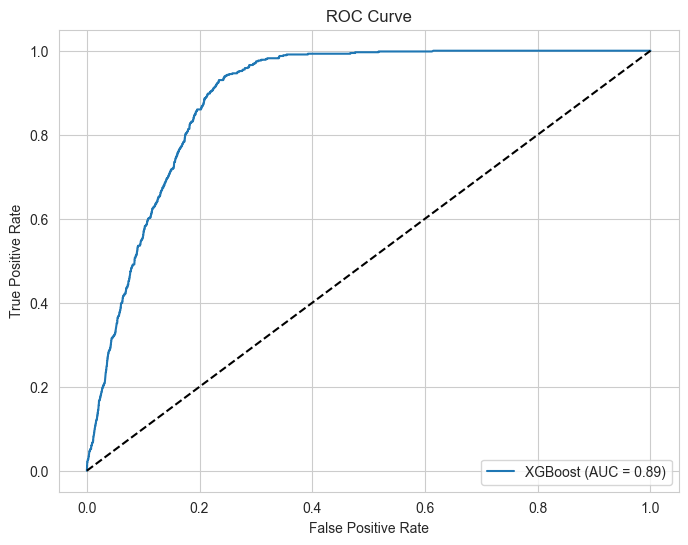

In [11]:
# c. Evaluation
y_pred_freq = xgb_clf.predict(X_freq_test)
y_proba_freq = xgb_clf.predict_proba(X_freq_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_freq_test, y_pred_freq))
print(f"ROC-AUC Score: {roc_auc_score(y_freq_test, y_proba_freq):.4f}")

# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(y_freq_test, y_proba_freq)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_freq_test, y_proba_freq):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 5. Model Interpretation (SHAP)

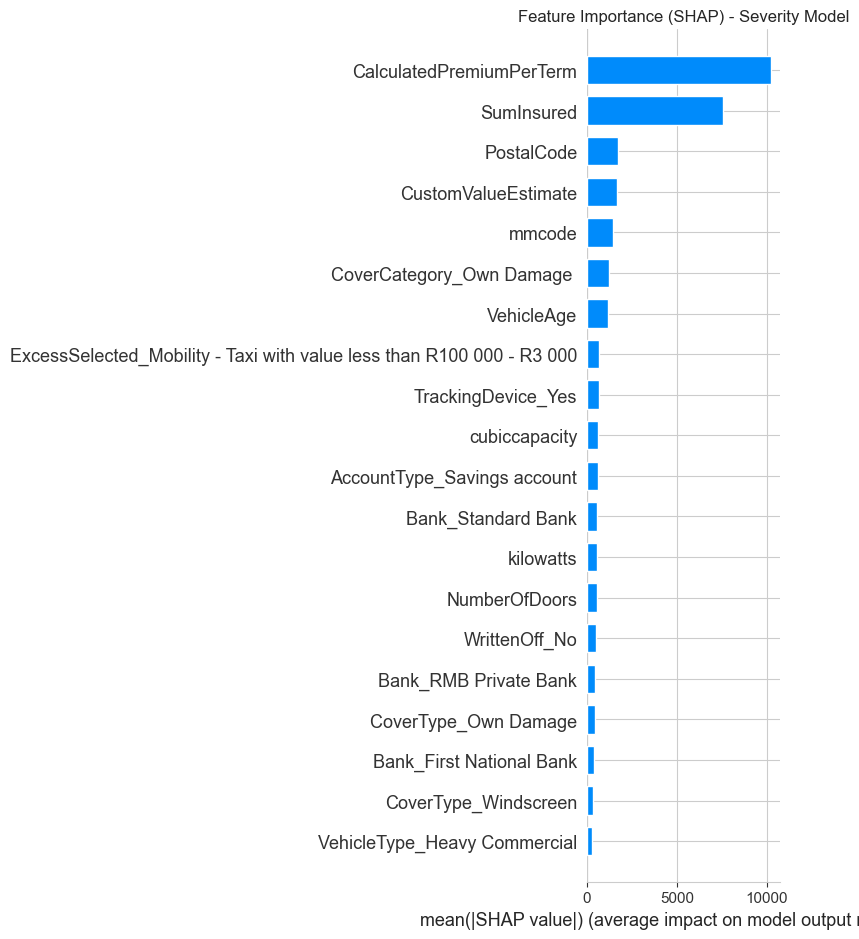

In [12]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_sev_test)

plt.title("Feature Importance (SHAP) - Severity Model")
shap.summary_plot(shap_values, X_sev_test, plot_type="bar")
plt.show()

## 6. Risk-Based Premium Calculation
The final goal is to calculate a premium that reflects the risk.
Formula:
$$ RiskPremium = P(Claim) \times E(Severity) $$

Where:
- $P(Claim)$ is the probability from the Classification Model.
- $E(Severity)$ is the predicted claim cost from the Regression Model.

       Predicted_Probability  Predicted_Severity   Risk_Premium
count          200020.000000       200020.000000  200020.000000
mean                0.179052        13607.750000    3573.901123
std                 0.298894        21199.632812   10847.870117
min                 0.000006       -36678.878906  -18244.365234
25%                 0.000509         2695.459473       1.756156
50%                 0.001203         4126.564453       5.436646
75%                 0.237999        19745.160156    1363.126465
max                 0.976172       367934.281250  346221.250000


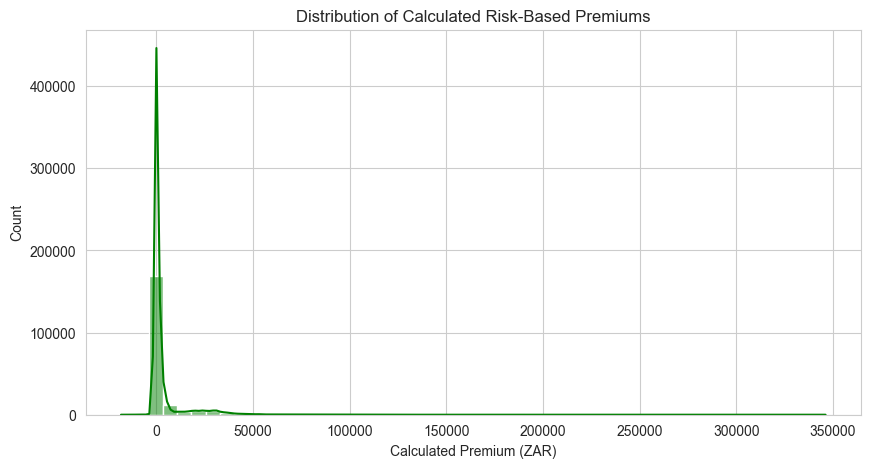

In [13]:
# Calculate Premium for the Test Set
# 1. Get Probability of Claim for ALL test instances
probs = xgb_clf.predict_proba(X_freq_test)[:, 1]

# 2. Get Predicted Severity for ALL test instances 
# (Using the severity model to predict hypothetical cost IF a claim occurred)
predicted_severity = xgb_model.predict(X_freq_test)

# 3. Calculate Risk Premium
risk_premiums = probs * predicted_severity

# Create a Results DataFrame
results_df = X_freq_test.copy()
results_df['Predicted_Probability'] = probs
results_df['Predicted_Severity'] = predicted_severity
results_df['Risk_Premium'] = risk_premiums

# Compare with existing 'TotalPremium' (we need to join back to original DF or use index if preserved)
# For now, let's look at the distribution of our calculated premiums
print(results_df[['Predicted_Probability', 'Predicted_Severity', 'Risk_Premium']].describe())

plt.figure(figsize=(10, 5))
sns.histplot(results_df['Risk_Premium'], bins=50, kde=True, color='green')
plt.title('Distribution of Calculated Risk-Based Premiums')
plt.xlabel('Calculated Premium (ZAR)')
plt.show()